In [1]:
"""Train Glow on CIFAR-10.

Train script adapted from: https://github.com/kuangliu/pytorch-cifar/
"""
import argparse
import numpy as np
import os
import random
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import util

from models import Glow
from tqdm import tqdm


root = "D:\_0Luciano\_0PHD\datasets"

In [2]:
batch_size=64 # type=int# help='Batch size per GPU')
benchmark = True # help='Turn on CUDNN benchmarking')
gpu_ids=[0]# type=eval# help='IDs of GPUs to use')
lr=1e-3# type=float# help='Learning rate')
max_grad_norm=-1.# help='Max gradient norm for clipping')
num_channels=512# type=int# help='Number of channels in hidden layers')
num_levels=3# type=int# help='Number of levels in the Glow model')
num_steps=32# type=int# help='Number of steps of flow in each level')
num_epochs=100# type=int# help='Number of epochs to train')
num_samples=64# type=int# help='Number of samples at test time')
num_workers=8# type=int# help='Number of data loader threads')
resume=False# help='Resume from checkpoint')
seed=0# help='Random seed for reproducibility')
warm_up=500000# type=int# help='Number of steps for lr warm-up')

best_loss = 0
global_step = 0

In [3]:
@torch.enable_grad()
def train(epoch, net, trainloader, device, optimizer, scheduler, loss_fn, max_grad_norm):
    global global_step
    print('\nEpoch: %d' % epoch)
    net.train()
    loss_meter = util.AverageMeter()
    with tqdm(total=len(trainloader.dataset)) as progress_bar:
        for x, _ in trainloader:
            x = x.to(device)
            optimizer.zero_grad()
            z, sldj = net(x, reverse=False)
            loss = loss_fn(z, sldj)
            loss_meter.update(loss.item(), x.size(0))
            loss.backward()
            if max_grad_norm > 0:
                util.clip_grad_norm(optimizer, max_grad_norm)
            optimizer.step()
            scheduler.step(global_step)

            progress_bar.set_postfix(nll=loss_meter.avg,
                                     bpd=util.bits_per_dim(x, loss_meter.avg),
                                     lr=optimizer.param_groups[0]['lr'])
            progress_bar.update(x.size(0))
            global_step += x.size(0)


@torch.no_grad()
def sample(net, batch_size, device):
    """Sample from RealNVP model.

    Args:
        net (torch.nn.DataParallel): The RealNVP model wrapped in DataParallel.
        batch_size (int): Number of samples to generate.
        device (torch.device): Device to use.
    """
    z = torch.randn((batch_size, 3, 32, 32), dtype=torch.float32, device=device)
    x, _ = net(z, reverse=True)
    x = torch.sigmoid(x)

    return x




In [6]:
root = "data"

# Set up main device and scale batch size
device = 'cuda' if torch.cuda.is_available() and gpu_ids else 'cpu'
batch_size *= max(1, len(gpu_ids))

# Set random seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# No normalization applied, since Glow expects inputs in (0, 1)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


In [7]:

trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


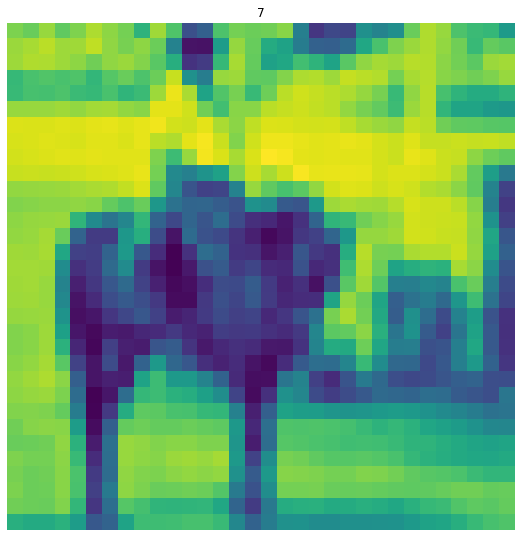

In [8]:
import matplotlib.pyplot as plt
from torchvision import utils
i=11

tensorImg = trainset[i][0]
numpyImg = tensorImg.numpy()[0]
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1); plt.imshow(numpyImg);  plt.axis('off')
plt.title(trainset[i][1])
plt.show()

torch.Size([64, 3, 32, 32])


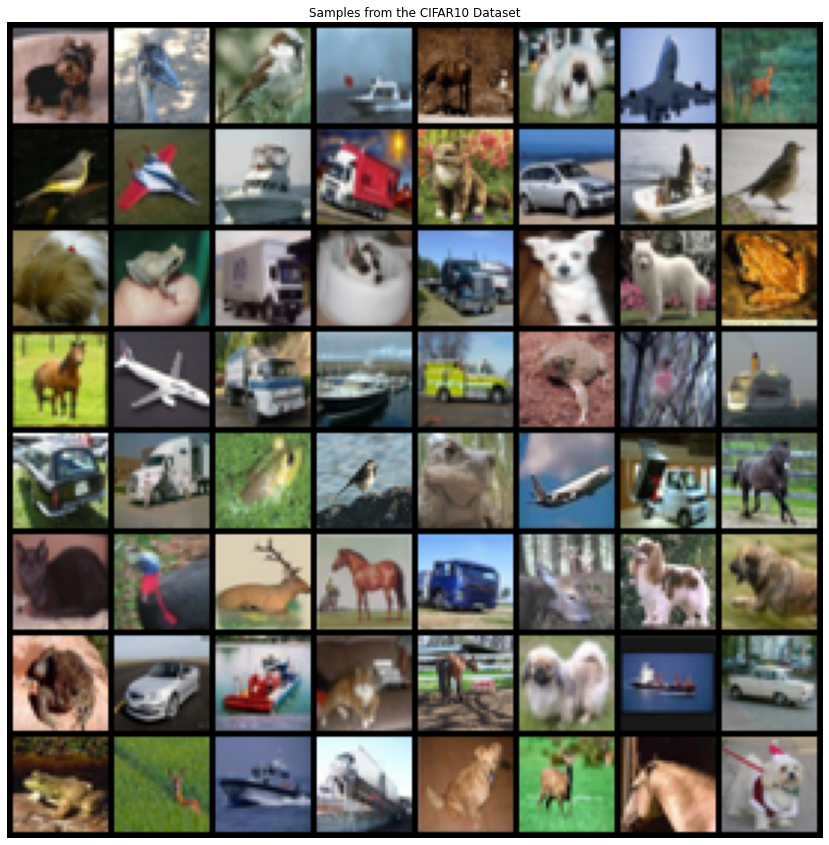

In [9]:
it=iter(trainloader)
real_batch = next(iter(it))
plt.figure(figsize=(15,15))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)),cmap='gray')
plt.axis('off')
plt.title('Samples from the CIFAR10 Dataset');
plt.show()

In [10]:
# Model
print('Building model..')
net = Glow(num_channels=num_channels,
            num_levels=num_levels,
            num_steps=num_steps)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net, gpu_ids)
    cudnn.benchmark = benchmark


Building model..


In [16]:
start_epoch = 0
if resume:
    # Load checkpoint.
    print('Resuming from checkpoint at ckpts/best.pth.tar...')
    assert os.path.isdir('ckpts'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('ckpts/best.pth.tar')
    net.load_state_dict(checkpoint['net'])
    global best_loss
    global global_step
    best_loss = checkpoint['test_loss']
    start_epoch = checkpoint['epoch']
    global_step = start_epoch * len(trainset)

loss_fn = util.NLLLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = sched.LambdaLR(optimizer, lambda s: min(1., s / warm_up))

In [15]:
@torch.no_grad()
def test(epoch, net, testloader, device, loss_fn, num_samples):
    global best_loss
    net.eval()
    loss_meter = util.AverageMeter()
    with tqdm(total=len(testloader.dataset)) as progress_bar:
        for x, _ in testloader:
            x = x.to(device)
            z, sldj = net(x, reverse=False)
            loss = loss_fn(z, sldj)
            loss_meter.update(loss.item(), x.size(0))
            progress_bar.set_postfix(nll=loss_meter.avg,
                                     bpd=util.bits_per_dim(x, loss_meter.avg))
            progress_bar.update(x.size(0))

    # Save checkpoint
    if loss_meter.avg < best_loss:
        print('Saving...')
        state = {
            'net': net.state_dict(),
            'test_loss': loss_meter.avg,
            'epoch': epoch,
        }
        os.makedirs('ckpts', exist_ok=True)
        torch.save(state, 'ckpts/best.pth.tar')
        best_loss = loss_meter.avg

    # Save samples and data
    images = sample(net, num_samples, device)
    os.makedirs('samples', exist_ok=True)
    images_concat = torchvision.utils.make_grid(images, nrow=int(num_samples ** 0.5), padding=2, pad_value=255)
    torchvision.utils.save_image(images_concat, 'samples/epoch_{}.png'.format(epoch))

In [17]:

for epoch in range(start_epoch, start_epoch + num_epochs):
    train(epoch, net, trainloader, device, optimizer, scheduler,
            loss_fn, max_grad_norm)
    test(epoch, net, testloader, device, loss_fn, num_samples)


  0%|          | 0/50000 [00:00<?, ?it/s]


Epoch: 0
